In [37]:
import numpy as np
import pandas as pd
from format_data import *
from preprocess import *
from plots import *
from utils import *

In [2]:
Db=pd.read_excel('table.xlsx')

In [ ]:
preprocessed_Db = preprocess_supervised(Db, output_col=OutputColumn.yield_strength, all_welds=False)
y=preprocessed_Db['output']
X=preprocessed_Db.drop('output', axis=1)

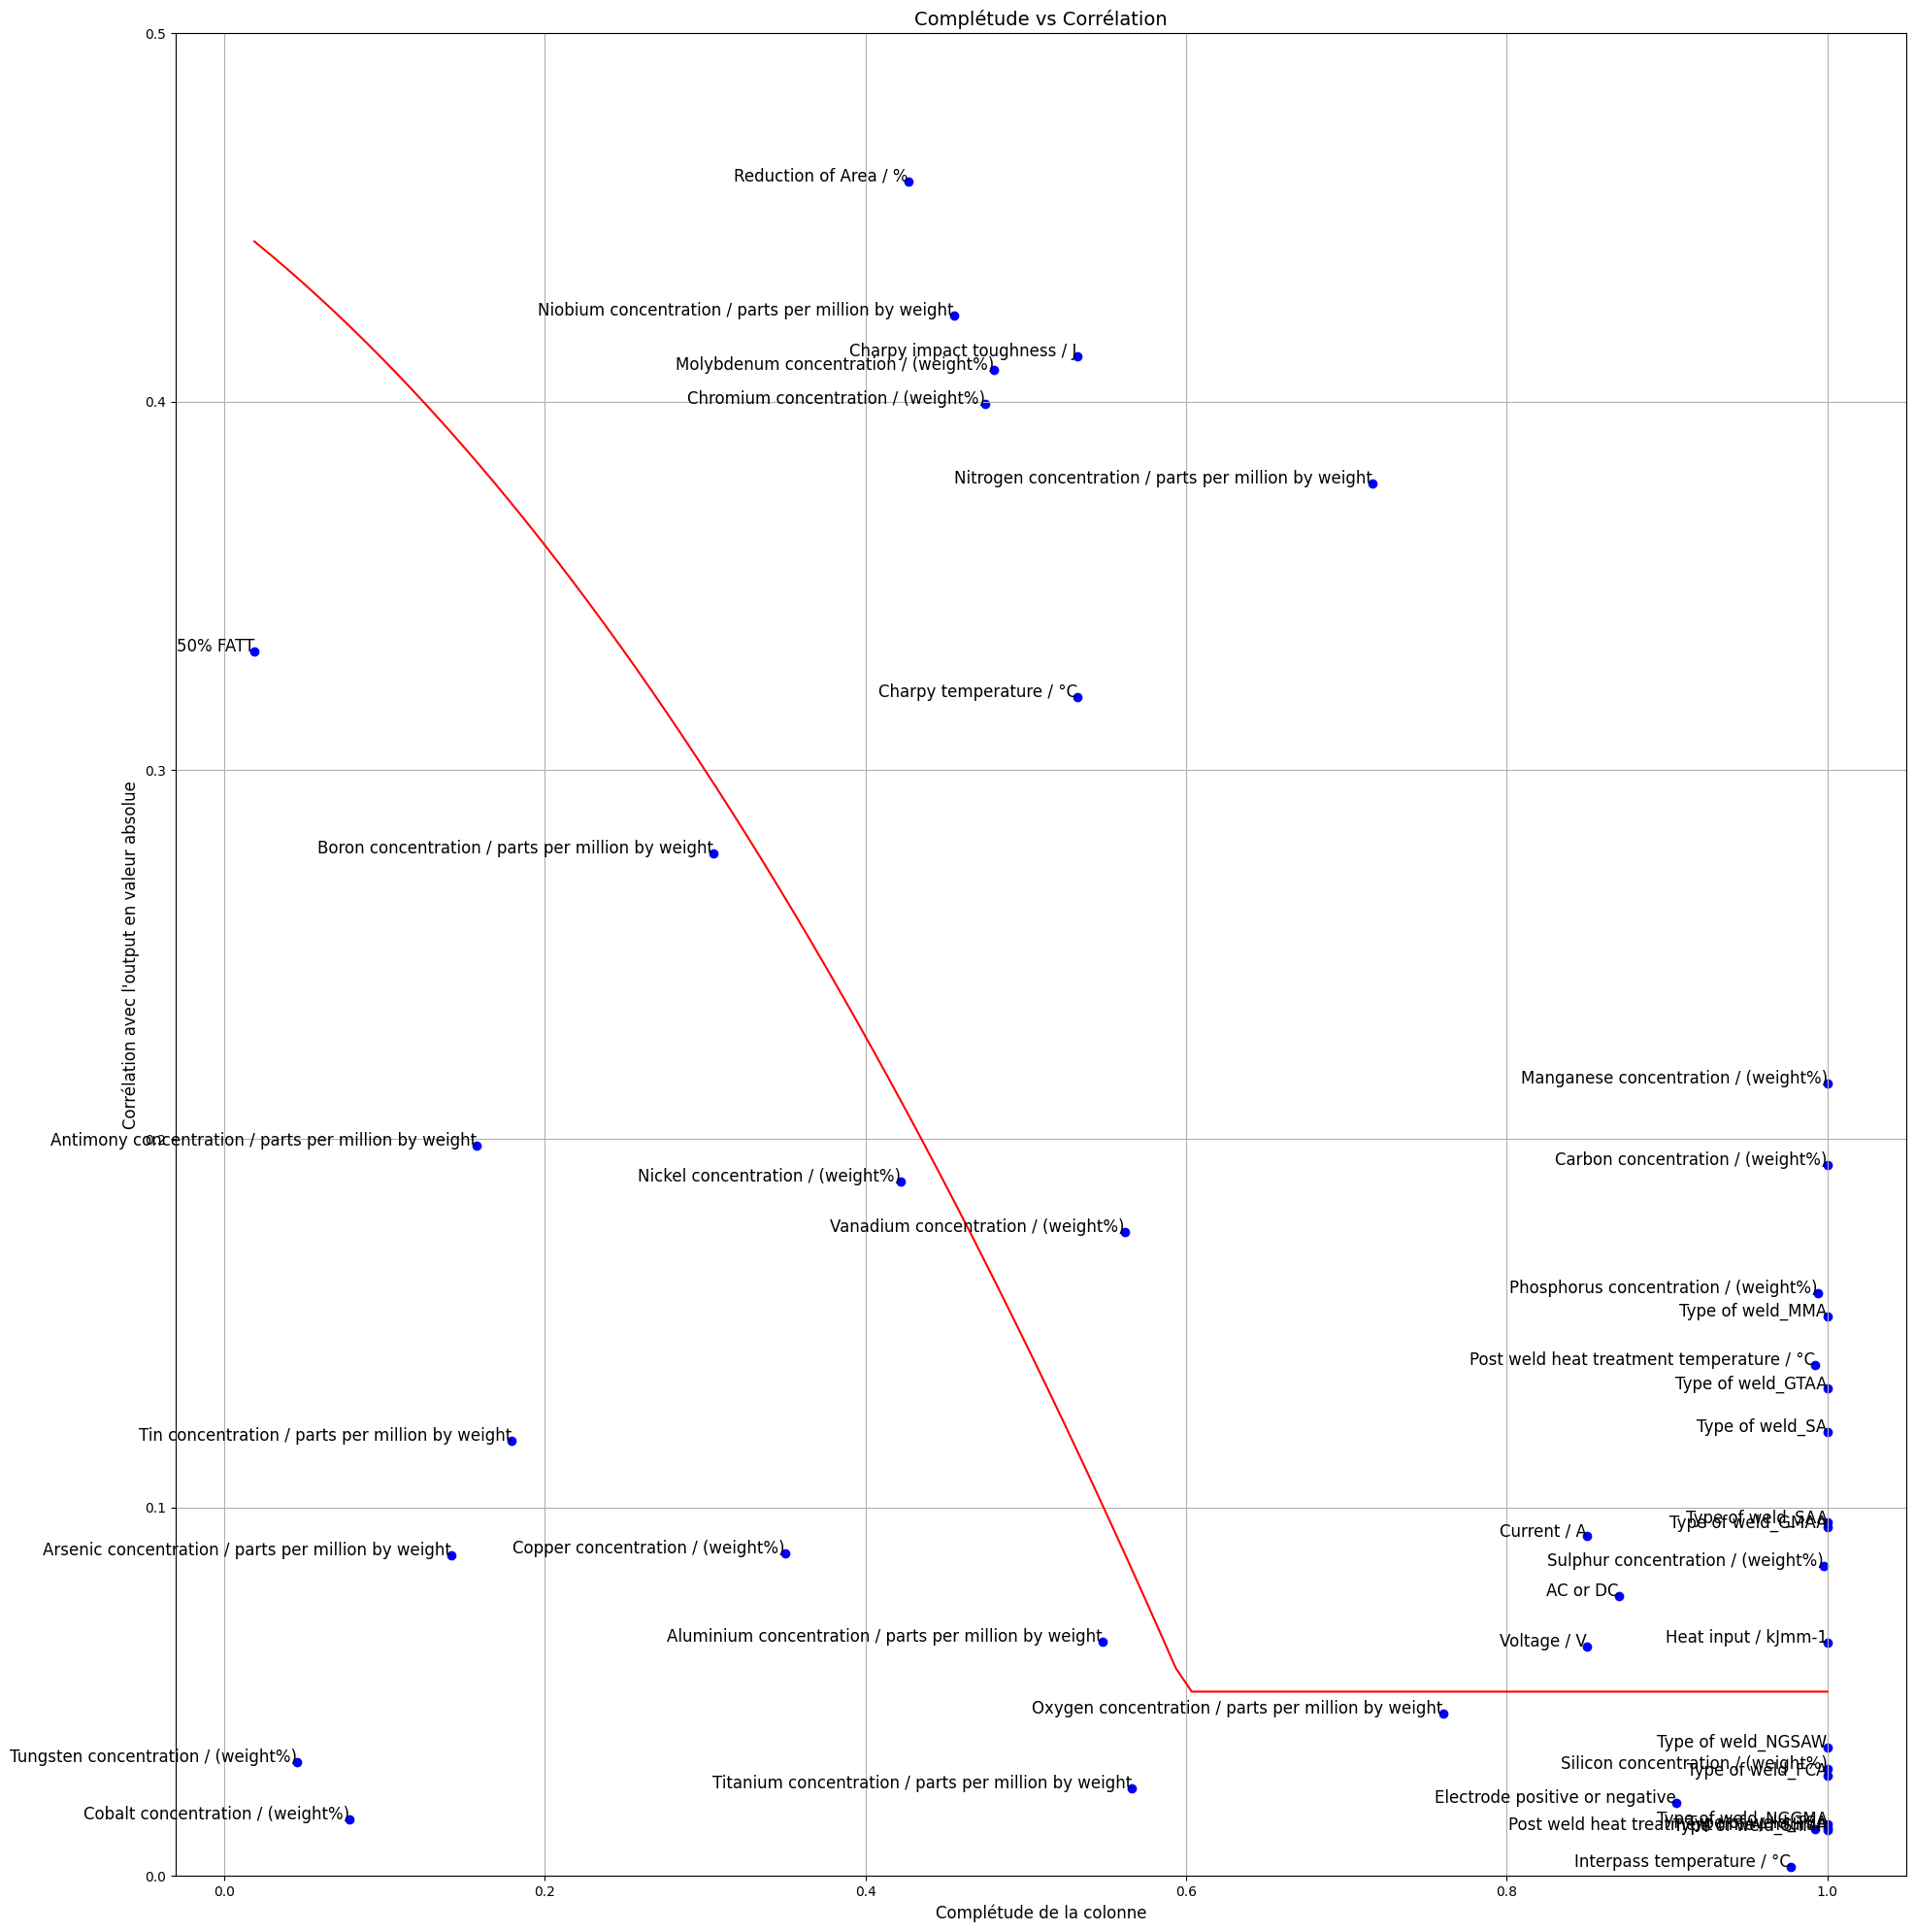

In [4]:
Db = Db.rename(columns={OutputColumn.yield_strength.value: 'output'})
features = list(set(Db.columns)-set(MECHANICAL_PROPERTIES))

# For the supervised approach we only keep the rows with an output
reduced_Db=Db.dropna(subset=['output'])
corr = get_corr(Db)
plot_completeness_vs_corr(corr)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


pipeline =  lambda degree : Pipeline([('poly_features', PolynomialFeatures(degree=degree)),('linreg', LinearRegression())])

In [50]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
from models import cross_validation
cross_validation(pipeline(1), X.values, y.values, per_weld=True)

{'MSE': np.float64(0.7545456334305624),
 'R²': np.float64(0.23731554053998574),
 'Bias': np.float64(0.0011355499692373213),
 'Variance': np.float64(0.32625765871341805)}

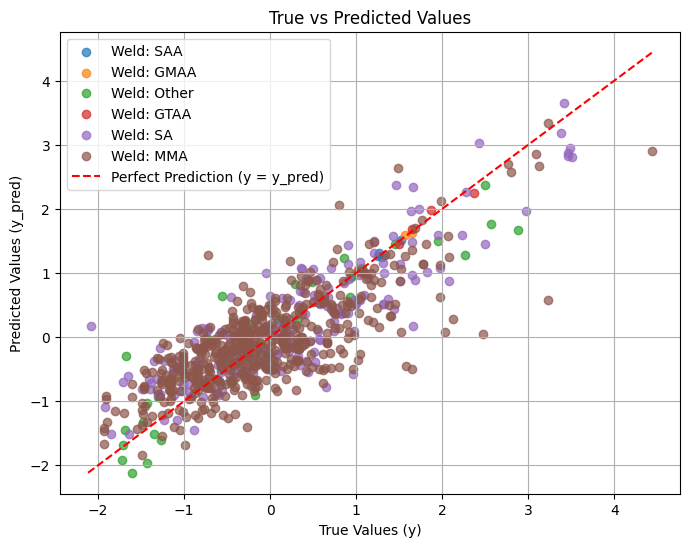

In [67]:
model=pipeline(2)
welds = weld_type(X)


model.fit(X,y)
y_pred = model.predict(X)
plot_y_pred(y, y_pred, welds)

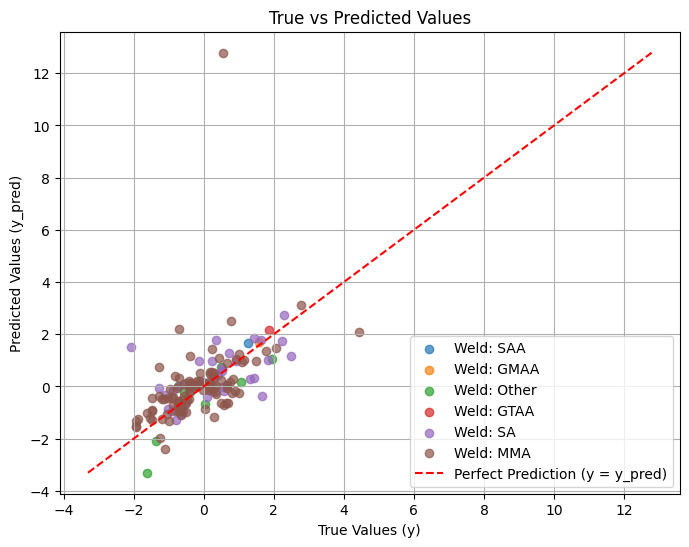

In [75]:
from sklearn.model_selection import train_test_split
import numpy as np
# Split the data: 80% training, 20% testing with stratification on weld types
X_train, X_test, y_train, y_test, weld_train, weld_test = train_test_split(
    X, y, welds, test_size=0.2, random_state=42, stratify=welds
)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Plot the predictions vs true values on the test set with weld types
plot_y_pred(y_test, y_pred, weld_test)

In [65]:
sum(welds.isna())

47

In [77]:
l=[]
for i in range(1,5):
    result = cross_validation(pipeline(i), X.values, y.values)
    l.append(result)
    print("polynomial regression degree", i)
    print(result)
    
bias = [x["Bias"] for x in l]
variance = [x["Variance"] for x in l]


polynomial regression degree 1
{'MSE': np.float64(0.7545456334305624), 'R²': np.float64(0.23731554053998574), 'Bias': np.float64(0.0011355499692373213), 'Variance': np.float64(0.32625765871341805)}
polynomial regression degree 2
{'MSE': np.float64(2.1095610103422305e+18), 'R²': np.float64(-2.743897742970322e+18), 'Bias': np.float64(65991954.91690068), 'Variance': np.float64(2.1052060724322086e+18)}
polynomial regression degree 3
{'MSE': np.float64(4252.907942458133), 'R²': np.float64(-5322.132686733994), 'Bias': np.float64(2.9261231592723345), 'Variance': np.float64(4250.258918261551)}
polynomial regression degree 4
{'MSE': np.float64(68542080.83647262), 'R²': np.float64(-65891072.631886825), 'Bias': np.float64(119.00450360856075), 'Variance': np.float64(68528052.83305705)}


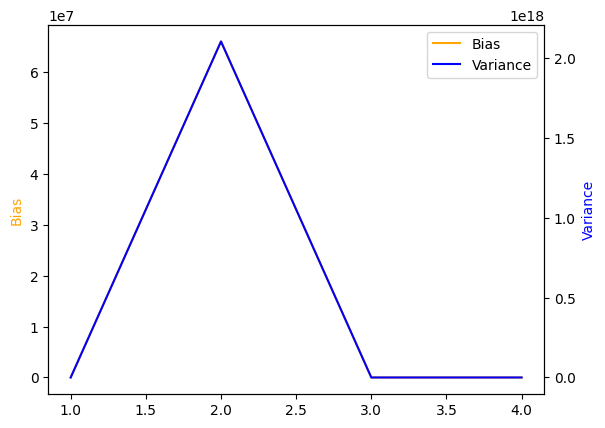

In [18]:
# Define subplots
fig, ax = plt.subplots()

# Add first line to the plot (for bias)
ax.plot(range(1, 5), bias, label='Bias', color='orange')
ax.set_ylabel('Bias', color='orange')

# Define second y-axis that shares x-axis with the current plot
ax2 = ax.twinx()

# Add second line to the plot (for variance)
ax2.plot(range(1, 5), variance, label='Variance', color='blue')
ax2.set_ylabel('Variance', color='blue')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show the plot
plt.show()